# Download data for pre-training. 
* Each scroll is veryyyyy large, so we need to do some pre-processing on the fly.


In [ ]:
# Failed
# rclone copy --transfers=4 --checkers=4 --tpslimit=2 -P   :http:full-scrolls/Scroll2/PHercParis3.volpkg/volumes_zarr_standardized/54keV_7.91um_Scroll2A.zarr/   /mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/DataSet/Pre-training/PHercParis3.zarr   --http-url https://dl.ash2txt.org/
# rclone copy --transfers=4 --checkers=4 --tpslimit=2 -P   :http:full-scrolls/Scroll4/PHerc1667.volpkg/volumes_zarr/20231107190228.zarr/   /mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/DataSet/Pre-training/PHerc1667.zarr   --http-url https://dl.ash2txt.org/
# rclone copy --transfers=4 --checkers=4 --tpslimit=2 -P   :http:full-scrolls/Scroll5/PHerc172.volpkg/volumes_zarr_standardized/53keV_7.91um_Scroll5.zarr/   /mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/DataSet/Pre-training/PHerc172.zarr   --http-url https://dl.ash2txt.org/

In [1]:
import os
import requests
import numpy as np
import tifffile
from bs4 import BeautifulSoup
from tqdm import tqdm
from urllib.parse import urljoin

# --- CONFIGURATION ---

"""
# List of available scrolls:
['https://dl.ash2txt.org/full-scrolls/Scroll2/PHercParis3.volpkg/volumes_zarr_standardized/54keV_7.91um_Scroll2A.zarr', 
'http:full-scrolls/Scroll3/PHerc332.volpkg/volumes_zarr_standardized/53keV_7.91um_Scroll3.zarr',
''
]
"""
TARGET_URL = "https://dl.ash2txt.org/full-scrolls/Scroll1/PHercParis4.volpkg/volumes_masked/20230205180739/"
DOWNLOAD_DIR = "./temp_raw_downloads"
OUTPUT_DIR = "../DataSet/Pre-training/cropped_output"

def get_tif_links(url):
    """Scrapes the directory for .tif files."""
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        links = [a['href'] for a in soup.find_all('a') if a['href'].endswith('.tif')]
        return sorted(links)
    except Exception as e:
        print(f"Error fetching links: {e}")
        return []


ModuleNotFoundError: No module named 'bs4'

In [3]:
def download_file(file_url, local_path):
    """Downloads a single file if it doesn't exist."""
    if os.path.exists(local_path):
        return
    
    with requests.get(file_url, stream=True) as r:
        r.raise_for_status()
        with open(local_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

In [4]:
import tifffile
import numpy as np

def crop_foreground(tiff_path, bounds):

    x_min = bounds['x_min']
    x_max = bounds['x_max']
    y_min = bounds['y_min']
    y_max = bounds['y_max']
    
    # Load image
    tiff_img = tifffile.imread(tiff_path)



    # Crop
    cropped = tiff_img[y_min:y_max+1, x_min:x_max+1]
    return cropped


In [5]:
def get_small_sample_list(tif_files):
    # Suppose tif_files is your list of file paths
    n_samples = 100

    # Handle case when there are fewer than 100 files
    n_samples = min(n_samples, len(tif_files))

    # Get 100 equally spaced indices
    indices = np.linspace(0, len(tif_files)-1, n_samples, dtype=int)

    # Select files
    selected_files = [tif_files[i] for i in indices]
    return selected_files



In [6]:
def calculate_global_bounds(file_list):
    """
    Iterates through 2D files to calculate the 3D bounding box 
    without loading the whole volume into RAM.
    Implements your 'detect_deges_with_content' logic iteratively.
    """
    print("\n--- Scanning files to calculate Global Bounding Box ---")
    
    # Initialize with inverted infinity to find min/max
    min_x, max_x = float('inf'), float('-inf')
    min_y, max_y = float('inf'), float('-inf')
    min_z, max_z = float('inf'), float('-inf')
    
    has_data = False

    for z_index, filename in enumerate(tqdm(file_list, desc="Scanning Geometry")):
        file_path = os.path.join(DOWNLOAD_DIR, filename)
        
        # Load 2D slice
        img = tifffile.imread(file_path)
        
        # Check if slice has any data (Your Z-axis check)
        if np.any(img > 0):
            # Update Z bounds
            if z_index < min_z: min_z = z_index
            if z_index > max_z: max_z = z_index
            
            has_data = True
            
            # Check Y axis (Rows) for this slice
            # np.any(img, axis=1) gives boolean array of rows containing data
            y_indices = np.where(np.any(img > 0, axis=1))[0]
            if len(y_indices) > 0:
                current_y_min, current_y_max = y_indices[0], y_indices[-1]
                min_y = min(min_y, current_y_min)
                max_y = max(max_y, current_y_max)

            # Check X axis (Cols) for this slice
            # np.any(img, axis=0) gives boolean array of cols containing data
            x_indices = np.where(np.any(img > 0, axis=0))[0]
            if len(x_indices) > 0:
                current_x_min, current_x_max = x_indices[0], x_indices[-1]
                min_x = min(min_x, current_x_min)
                max_x = max(max_x, current_x_max)

    if not has_data:
        return None

    # Convert to integers
    bounds = {
        'x_min': int(min_x), 'x_max': int(max_x),
        'y_min': int(min_y), 'y_max': int(max_y),
        'z_min': int(min_z), 'z_max': int(max_z)
    }
    return bounds

In [ ]:
# 1. Setup
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

# 2. Get File List
print("Fetching file list...")
tif_files = get_tif_links(TARGET_URL)
if not tif_files:
    print("No files found.")
    exit()
    
print(f"Found {len(tif_files)} files.")

# 3. Download (One by one), crop and store locally
# We will divide by chunks of x, y, 1024 -> so we can still have volumes, a good representation of data and save disk space
print("Downloading files...")

chunk_size = 1024

chunk_list = [tif_files[i:i + chunk_size] for i in range(0, len(tif_files), chunk_size)]

for chunk_idx, tif_files in enumerate(chunk_list):
    print(f"\nProcessing chunk {chunk_idx+1}/{len(chunk_list)}...")
    OUTPUT_DIR_chunk = os.path.join(OUTPUT_DIR, f"chunk_{chunk_idx}")
    os.makedirs(OUTPUT_DIR_chunk, exist_ok=True)
    
    for idx_z, f in enumerate(tqdm(tif_files, desc="Downloading")):
        url = urljoin(TARGET_URL, f)
        path = os.path.join(DOWNLOAD_DIR, f)
        download_file(url, path)
  
    # Calculate bounds
    bounds = calculate_global_bounds(tif_files)
    print(f"Current bounds at slice {idx_z}: {bounds}")
    
    for idx_z, f in enumerate(tqdm(tif_files, desc="Croping and Saving")):
        # crop edges without content, save and remove tmp file
        path = os.path.join(DOWNLOAD_DIR, f)
        cropped_numpy = crop_foreground(tiff_path=path, bounds=bounds)
        output_path = os.path.join(OUTPUT_DIR_chunk, f)
        tifffile.imwrite(output_path, cropped_numpy, compression='deflate')
        os.remove(path)


In [ ]:
import tifffile
import glob
import os
from tqdm import tqdm

# Path to your tiffs
TIFF_FOLDER = "/mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/notebooks/temp_raw_downloads"
files = sorted(glob.glob(os.path.join(TIFF_FOLDER, "*.tif")))

print(f"Scanning {len(files)} remaining files...")

for f in tqdm(files):
    print(f"{f}")
    # Just try to read the header/first byte to check validity
    tifffile.imread(f)
  

### See some data!

In [2]:
import zarr
import matplotlib.pyplot as plt
import numpy as np


def load_zarr(zarr_path, res='0'):
    # Open the Group
    # We use mode='r' for safety.
    root = zarr.open(zarr_path, mode='r')
    
    # Access the 'volume' array
    # This object behaves like a numpy array but reads from disk on demand
    try:
        vol = root['volume']
    except:
        vol = root[res]

    print("Data loaded successfully.")
    print(f"Volume Shape: {vol.shape}") # Expecting (Layers, Height, Width) or similar
    print(f"Data Type: {vol.dtype}")
    return vol

def plot_slice(vol, several_slices=False):
    # Define the slice
    # We pick the middle layer (Z-axis) to ensure we see content (top/bottom layers can be empty)
    z_index = vol.shape[0] // 2
    y_index = 0 #vol.shape[1] // 2
    x_index = 0 # vol.shape[2] // 2
    # Define crop coordinates (Top-Left x=0, y=0)
    x_crop = 10000
    y_crop = 10000
    
    # Load the specific crop into memory
    # Syntax: vol[z_index, y_start:y_end, x_start:x_end]
    if several_slices: 
        for i in range (0, vol.shape[0], 1000):
            crop = vol[i, y_index:y_index+y_crop, x_index:x_index+x_crop]

            # Plot the mask
            plt.figure(figsize=(6, 6))
            # We use 'gray' so 0 (False) is black and 1 (True) is white
            plt.imshow(crop) 
            plt.title("Crop")
            plt.axis('off')
            plt.show()
    else:
        crop = vol[z_index, y_index:y_index+y_crop, x_index:x_index+x_crop]
          
        # Plot the mask
        plt.figure(figsize=(6, 6))
        # We use 'gray' so 0 (False) is black and 1 (True) is white
        plt.imshow(crop) 
        plt.title("Crop")
        plt.axis('off')
        plt.show()

    

Data loaded successfully.
Volume Shape: (9778, 3550, 3400)
Data Type: uint8


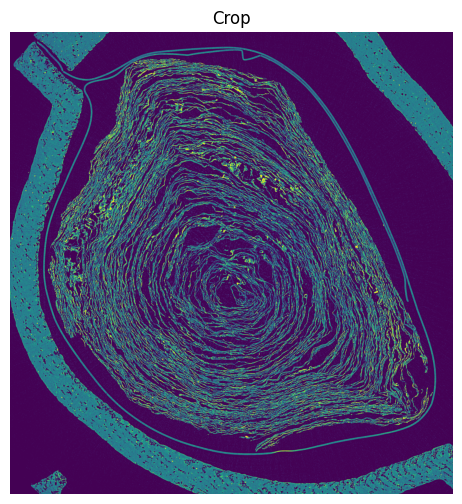

In [3]:
vol = load_zarr(zarr_path='/mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/DataSet/Pre-training/PHerc332.zarr', res='0')
plot_slice(vol)


/mounts/andre/.conda/envs/vesuvius/lib/python3.11/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


Data loaded successfully.
Volume Shape: (9778, 3550, 3400)
Data Type: uint8


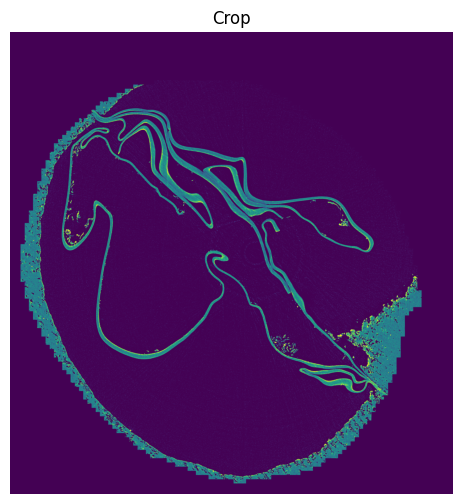

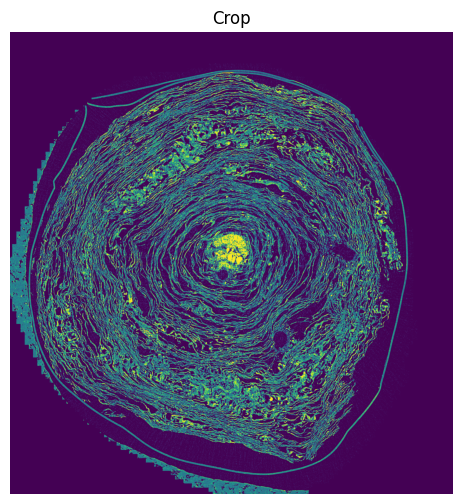

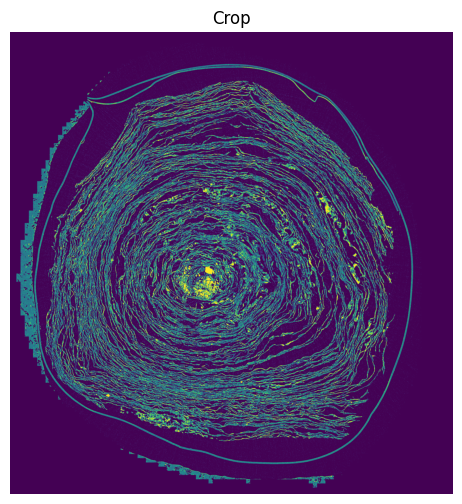

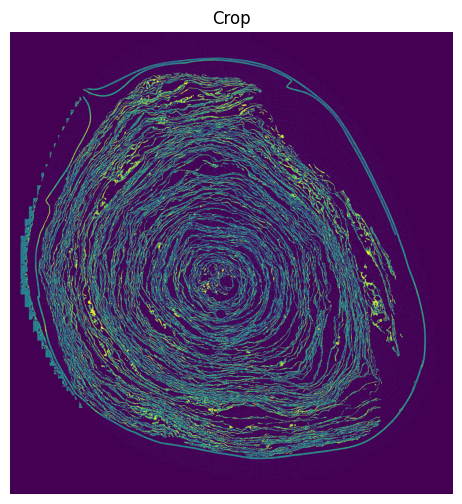

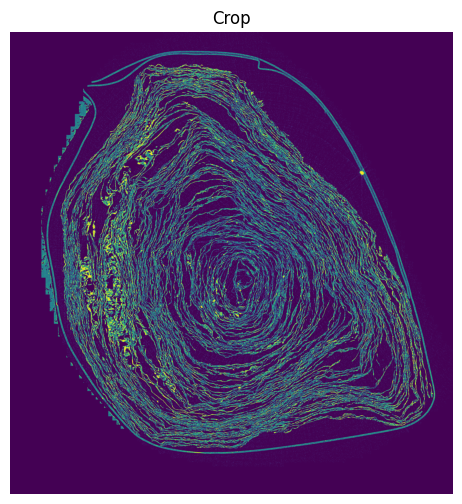

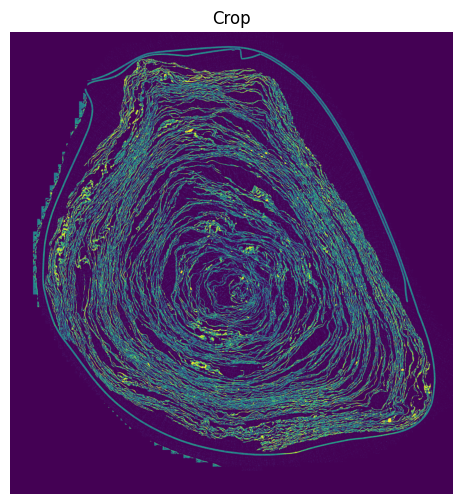

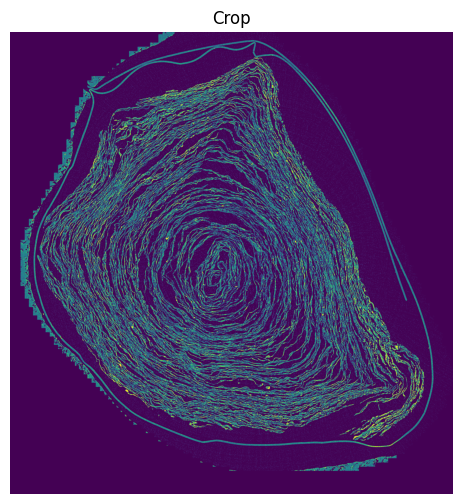

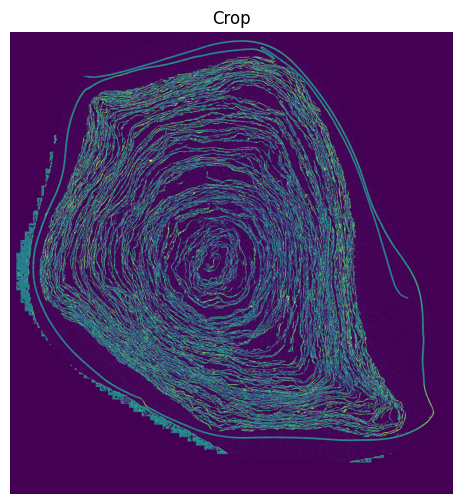

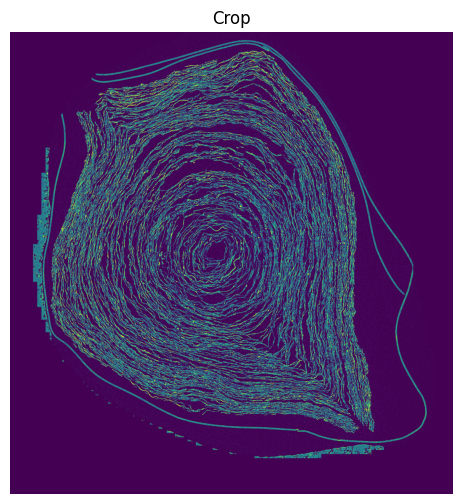

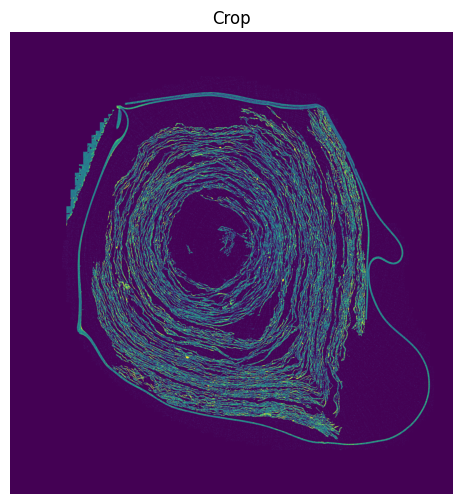

In [5]:
vol = load_zarr(zarr_path='/mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/DataSet/Pre-training/PHerc332_masked.zarr', res='0')
plot_slice(vol, several_slices=True)


In [ ]:
vol = load_zarr(zarr_path='/mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/DataSet/Pre-training/PHerc332.zarr', res='0')
plot_slice(vol, several_slices=True)


### Save the low resolution scan to create a rough mask

In [ ]:
import numpy as np
import nibabel as nib
import os

def save_lowres(vol, zarr_path, res_factor):
    # --- 1. Load Data (Already done in your snippet) ---
    # Assuming 'vol' is your Zarr array or loaded data
    full_sample = vol[:,:,:] 
    print(f"Data Loaded. Shape: {full_sample.shape}, Dtype: {full_sample.dtype}")
    
    full_sample[::factor, :, :]
    # --- 2. Calculate Statistics ---
    p_min = np.percentile(full_sample, 0.1) 
    p_max = np.percentile(full_sample, 99.9)
    
    print(f"Windowing: {p_min} to {p_max}")
    
    # --- 3. Apply Windowing (The Math) ---
    # We work on 'full_sample' directly
    # A. Clip outliers
    img_processed = np.clip(full_sample, p_min, p_max)
    
    # B. Normalize to 0.0 - 1.0
    # We use .astype(float) to prevent integer division errors if input is uint16
    img_processed = (img_processed.astype(np.float32) - p_min) / (p_max - p_min)
    
    # C. Scale to 255
    img_processed = img_processed * 255.0
    
    # D. Round and Cast to uint8 (CRITICAL STEP)
    img_final = np.round(img_processed).astype(np.uint8)
    
    # --- 4. Save as NIfTI (.nii.gz) ---
     # '/mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/DataSet/Pre-training/PHerc1667_Nov17.zarr'
    file_name = zarr_path.split('/')[-1].split('.zarr')[0]
    save_path = zarr_path.split(file_name)[0]
    file_name = f"{file_name}.nii.gz"
    save_path = os.path.join(save_path, file_name)
    
    # np.eye(4) 
    affine = np.eye(4)
    
    nifti_img = nib.Nifti1Image(img_final, affine)
    nib.save(nifti_img, save_path)
    
    print(f"✅ Success! Saved to {save_path}")
    return img_final

In [ ]:
zarr_path = '/mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/DataSet/Pre-training/PHerc332.zarr'
vol = load_zarr(zarr_path=zarr_path, res='5')
img_final_unit8 = save_lowres(vol, zarr_path, res_factor=2)

In [ ]:
import zarr
import numpy as np
import matplotlib.pyplot as plt

def check_damage(vol):
    # Grab a slice from the middle
    mid_z = vol.shape[0] // 2
    img_slice = vol[mid_z]
    
    print(f"Slice Statistics:")
    print(f"Min: {np.min(img_slice)}")
    print(f"Max: {np.max(img_slice)}")
    print(f"Mean: {np.mean(img_slice)}")
    
    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(img_slice.flatten(), bins=255, range=(1, 255)) # Ignore 0 (background)
    plt.title("Histogram of Converted Data (Does it look 'squashed'?)")
    plt.xlabel("Pixel Value (0-255)")
    plt.ylabel("Count")
    plt.show()

check_damage(img_final_unit8)

In [ ]:
import nibabel as nib
import numpy as np

def apply_mask(mask_file):
    # Load mask
    mask = nib.load(mask_file).get_fdata()
    
    # Ensure mask is same shape as img_final
    print(img_final.shape, mask.shape)
    
    # Apply mask
    img_final_crop = img_final * mask
    
    # --- 4. Save as NIfTI (.nii.gz) ---
    file_name = zarr_path.split('/')[-1].split('.zarr')[0]
    save_path = zarr_path.split(file_name)[0]
    file_name = f"{file_name}_crop.nii.gz"
    save_path = os.path.join(save_path, file_name)
    
    # np.eye(4) 
    affine = np.eye(4)
    
    nifti_img = nib.Nifti1Image(img_final_crop, affine)
    nib.save(nifti_img, save_path)
    
    print(f"✅ Success! Saved to {save_path}")
    return img_final_crop

In [ ]:
mask_file = "/mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/DataSet/Pre-training/PHerc1667_Nov17_1_mask.nii.gz"
img_final_crop = apply_mask(mask_file)
check_damage(img_final_crop)

### Apply mask to the full scan

In [4]:
import zarr
import nibabel as nib
import numpy as np
import scipy.ndimage
from tqdm import tqdm
import math
import gc
# Use the codec from numcodecs if possible, or just zarr wrappers
from zarr.codecs import Blosc

# ================= CONFIGURATION =================
# Path to your High-Res Zarr
ZARR_PATH_IN = '/mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/DataSet/Pre-training/PHerc332.zarr'

# Output Path (Where the masked data will go)
ZARR_PATH_OUT = '/mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/DataSet/Pre-training/PHerc332_masked.zarr'

# Path to your Low-Res Mask
MASK_PATH = "/mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/DataSet/Pre-training/Downsample/PHerc332_downsampled_mask.nii" 

# How many Z-slices to process at once?
# 500 slices * 8000 * 8000 pixels * 1 byte = ~32 GB RAM per batch.
# With 252 GB RAM, you can safely do 500-1000.
SLAB_SIZE = 500 

# Threshold (Mask is 0 or 1, so 0.5 works)
MASK_THRESHOLD = 0.5 

# =================================================

def estimate_global_stats(vol, samples=100):
    """
    Reads random slices to estimate p_min and p_max for the WHOLE volume.
    This ensures consistent brightness across all slabs.
    """
    print(f"   calibrating contrast (reading {samples} random slices)...")
    z_depth = vol.shape[0]
    # Pick random indices
    indices = np.linspace(0, z_depth-1, samples, dtype=int)
    
    pixel_buffer = []
    for z in indices:
        # Read one slice
        slc = vol[z, :, :]
        pixel_buffer.append(slc.flatten())
    
    full_sample = np.concatenate(pixel_buffer)
    
    # Calculate robust percentiles for Surface Detection
    # 0.1% bottom (ignore dead pixels)
    # 99.9% top (ignore metal artifacts)
    p_min = np.percentile(full_sample, 0.1)
    p_max = np.percentile(full_sample, 99.9)
    
    print(f"   Calibration Complete: Clip range [{p_min:.1f}, {p_max:.1f}]")
    return p_min, p_max
    
def apply_mask_convert_save():
    # 1. Open Source
    print(f"Opening Source: {ZARR_PATH_IN}")
    src_vol = load_zarr(ZARR_PATH_IN, res='0')
    print(f"   Input: {src_vol.shape} | {src_vol.dtype}")

    # 2. Calibration (Get stats for uint8 conversion)
    p_min, p_max = estimate_global_stats(src_vol)

    # 3. Create Output (uint8)
    print(f"Creating Output: {ZARR_PATH_OUT}")
    root_out = zarr.open(ZARR_PATH_OUT, mode='w')
    
    # Zstd with Bitshuffle is best for masks + images
    compressor = Blosc(cname='zstd', clevel=3, shuffle=2)
    
    dst_vol = root_out.create_dataset('0', 
                                      shape=src_vol.shape, 
                                      chunks=src_vol.chunks, 
                                      dtype=np.uint8,  # <--- FORCE UINT8 HERE
                                      compressor=compressor,
                                      overwrite=True)
    
    # Copy metadata
    if hasattr(src_vol, 'attrs'):
        try: dst_vol.attrs.update(src_vol.attrs)
        except: pass

    # 4. Load Mask
    print(f"Loading Mask...")
    mask_nii = nib.load(MASK_PATH)
    mask_data = mask_nii.get_fdata()
    
    z_shape, y_shape, x_shape = src_vol.shape
    scale_z = mask_data.shape[0] / z_shape
    scale_y = mask_data.shape[1] / y_shape
    scale_x = mask_data.shape[2] / x_shape

    # 5. Process Slabs
    total_slabs = math.ceil(z_shape / SLAB_SIZE)
    print(f"   Processing {total_slabs} slabs...")

    for i in tqdm(range(total_slabs)):
        z_start = i * SLAB_SIZE
        z_end = min((i + 1) * SLAB_SIZE, z_shape)
        current_depth = z_end - z_start
        
        # A. Read High-Res Slab (uint16)
        # Convert to float32 immediately for math
        slab_data = src_vol[z_start:z_end, :, :].astype(np.float32)
        
        # B. Prepare Mask
        mz_start = int(z_start * scale_z)
        mz_end = min(int(math.ceil(z_end * scale_z)), mask_data.shape[0])
        mask_slab_low = mask_data[mz_start:mz_end, :, :]
        
        if mask_slab_low.size == 0:
            mask_slab_high = np.zeros(slab_data.shape, dtype=bool)
        else:
            zoom_z = current_depth / mask_slab_low.shape[0]
            zoom_y = y_shape / mask_slab_low.shape[1]
            zoom_x = x_shape / mask_slab_low.shape[2]
            mask_slab_high = scipy.ndimage.zoom(mask_slab_low, (zoom_z, zoom_y, zoom_x), order=0)
            
        if mask_slab_high.shape != slab_data.shape:
             mask_slab_high = mask_slab_high[:current_depth, :y_shape, :x_shape]
        
        # --- C. CORE LOGIC: WINDOWING & CONVERSION ---
        
        # 1. Clip Outliers (Metal/Air)
        np.clip(slab_data, p_min, p_max, out=slab_data)
        
        # 2. Normalize to 0..1
        slab_data -= p_min
        slab_data /= (p_max - p_min)
        
        # 3. Scale to 255
        slab_data *= 255.0
        
        # 4. Apply Mask (Set background to exactly 0)
        # Doing this BEFORE casting ensures clean zeros
        slab_data[mask_slab_high < MASK_THRESHOLD] = 0
        
        # 5. Round and Cast to uint8
        slab_uint8 = np.round(slab_data).astype(np.uint8)
        
        # D. Write to Disk
        dst_vol[z_start:z_end, :, :] = slab_uint8
        
        del slab_data, slab_uint8, mask_slab_high
        gc.collect()

    print("✅ Done. Converted to uint8 + Masked.")

apply_mask_convert_save()

Opening Source: /mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/DataSet/Pre-training/PHerc332.zarr
Data loaded successfully.
Volume Shape: (9778, 3550, 3400)
Data Type: uint8
   Input: (9778, 3550, 3400) | uint8
   calibrating contrast (reading 100 random slices)...


/mounts/andre/.conda/envs/vesuvius/lib/python3.11/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/tmp/ipykernel_1916/1134842390.py:74: ZarrDeprecationWarning: Use Group.create_array instead.
  dst_vol = root_out.create_dataset('0',
/mounts/andre/.conda/envs/vesuvius/lib/python3.11/site-packages/zarr/core/group.py:1139: ZarrUserWarning: The `compressor` argument is deprecated. Use `compressors` instead.
  compressors = _parse_deprecated_compressor(


   Calibration Complete: Clip range [0.0, 248.0]
Creating Output: /mounts/disk4_tiago_e_andre/vesuvius/Vesuvius/DataSet/Pre-training/PHerc332_masked.zarr
Loading Mask...
   Processing 20 slabs...


100%|██████████| 20/20 [39:20<00:00, 118.03s/it]

✅ Done. Converted to uint8 + Masked.
